In [ ]:
import sys, platform
%pip install pycocotools
from PIL import Image
from pathlib import Path
from torchvision.datasets import CocoDetection
from pycocotools.coco import COCO
from pathlib import Path
import random
import numpy as np
import torch, torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms.functional as F
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torch.optim import AdamW
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [12]:
ROOT = Path("signs_coco")
IMG_DIR = ROOT / "images"
ANN_FILE = ROOT / "result.json"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [13]:
def transforms(img, target):
    img = F.to_tensor(img)
    return img, target

ATTRIBUTE_NAMES = {
    "Front", "Side", "Back",
    "Wall-mounted", "Pole-mounted",
    "Good", "Weathered", "Heavily Damaged", "Damaged",
    "Circular", "Square", "Triangular", "Octagonal",
}

class CocoForSignTypeDetection(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms
        self.img_folder = Path(img_folder)

        cats = self.coco.loadCats(self.coco.getCatIds())
        cats = sorted(cats, key=lambda c: c["id"])

        sign_cats = [c for c in cats if c["name"] not in ATTRIBUTE_NAMES]

        self.cat_id_to_contig = {c["id"]: i + 1 for i, c in enumerate(sign_cats)}
        self.contig_to_name = {i + 1: c["name"] for i, c in enumerate(sign_cats)}
        self.contig_to_cat_id = {v: k for k, v in self.cat_id_to_contig.items()}
        self.num_classes = len(sign_cats) + 1

        self._kept_names = [c["name"] for c in sign_cats]
        self._dropped_names = [c["name"] for c in cats if c["name"] in ATTRIBUTE_NAMES]

    def _load_image(self, id: int):
        # COCO json file_name may contain a Label Studio path; we only want the basename
        file_name = self.coco.loadImgs(id)[0]["file_name"]
        base = Path(file_name).name  # strips ../../label-studio/... and keeps IMG_xxx.jpg
        img_path = self.img_folder / base
        return Image.open(img_path).convert("RGB")

    def __getitem__(self, idx):
        id = self.ids[idx]
        img = self._load_image(id)
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=id))

        boxes, labels = [], []
        for a in anns:
            coco_cat_id = a["category_id"]
            if coco_cat_id not in self.cat_id_to_contig:
                continue

            x, y, w, h = a["bbox"]
            if w <= 1 or h <= 1:
                continue
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_contig[coco_cat_id])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([id]),
        }

        if self._transforms:
            img, target = self._transforms(img, target)

        return img, target

dataset = CocoForSignTypeDetection(str(IMG_DIR), str(ANN_FILE), transforms=transforms)

print("Dropped attribute categories:", sorted(dataset._dropped_names))
print("Number of sign-type classes:", dataset.num_classes - 1)
print("num_classes (incl background):", dataset.num_classes)

found = 0
for i in range(len(dataset)):
    img, tgt = dataset[i]
    if len(tgt["boxes"]) > 0:
        print("Example idx:", i, "boxes:", len(tgt["boxes"]), "labels sample:", tgt["labels"][:5].tolist())
        found += 1
    if found == 3:
        break

print("Found:", found)



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dropped attribute categories: ['Back', 'Circular', 'Damaged', 'Front', 'Good', 'Heavily Damaged', 'Octagonal', 'Pole-mounted', 'Side', 'Square', 'Triangular', 'Wall-mounted', 'Weathered']
Number of sign-type classes: 25
num_classes (incl background): 26
Example idx: 0 boxes: 3 labels sample: [19, 22, 6]
Example idx: 1 boxes: 2 labels sample: [22, 19]
Example idx: 2 boxes: 2 labels sample: [19, 22]
Found: 3


In [14]:
indices = list(range(len(dataset)))
random.seed(42)
random.shuffle(indices)

split = int(0.8 * len(indices))
train_ds = Subset(dataset, indices[:split])
val_ds   = Subset(dataset, indices[split:])

print("Train:", len(train_ds), "Val:", len(val_ds))


Train: 481 Val: 121


In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

BATCH_SIZE = 2      
NUM_WORKERS = 0     

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn
)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT

model = torchvision.models.detection.retinanet_resnet50_fpn(weights=weights)

from torchvision.models.detection.retinanet import RetinaNetClassificationHead
num_anchors = model.head.classification_head.num_anchors

first_block = model.head.classification_head.conv[0]
conv0 = first_block[0]  
in_channels = conv0.in_channels

model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=dataset.num_classes 
)

model.to(device)
print("Model ready. Classes incl background:", dataset.num_classes)
print("Head num_classes:", model.head.classification_head.num_classes)



Model ready. Classes incl background: 26
Head num_classes: 26


In [17]:
CKPT_DIR = Path("checkpoints")
CKPT_DIR.mkdir(exist_ok=True)

def save_checkpoint(epoch, model, optimizer, avg_loss):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "avg_loss": avg_loss,
        "num_classes": dataset.num_classes,
        "kept_names": getattr(dataset, "_kept_names", None),
    }
    torch.save(ckpt, CKPT_DIR / f"retinanet_epoch{epoch}.pth")


In [18]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [19]:
model.train()
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

loss_dict = model(images, targets)
loss = sum(loss_dict.values())

optimizer.zero_grad()
loss.backward()
optimizer.step()

print({k: float(v.detach().cpu()) for k, v in loss_dict.items()})


{'classification': 1.2318074703216553, 'bbox_regression': 0.675222635269165}


In [20]:
from tqdm import tqdm
import time

EPOCHS = 20
ACCUM_STEPS = 1  

def train_one_epoch(epoch):
    model.train()
    running = 0.0
    optimizer.zero_grad()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, targets) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values()) / ACCUM_STEPS
        loss.backward()

        if (step + 1) % ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        running += loss.item() * ACCUM_STEPS
        pbar.set_description(f"Epoch {epoch} | avg loss {running/(step+1):.4f}")

    optimizer.step()
    optimizer.zero_grad()
    return running / max(1, len(train_loader))

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    avg_loss = train_one_epoch(epoch)
    print(f"Epoch {epoch}/{EPOCHS} | avg loss={avg_loss:.4f} | time={time.time()-t0:.1f}s")
    save_checkpoint(epoch, model, optimizer, avg_loss)



Epoch 1 | avg loss 1.2345: 100%|██████████| 241/241 [02:01<00:00,  1.99it/s]


Epoch 1/20 | avg loss=1.2345 | time=121.4s


Epoch 2 | avg loss 0.9207: 100%|██████████| 241/241 [01:57<00:00,  2.05it/s]


Epoch 2/20 | avg loss=0.9207 | time=117.4s


Epoch 3 | avg loss 0.8148: 100%|██████████| 241/241 [01:54<00:00,  2.11it/s]


Epoch 3/20 | avg loss=0.8148 | time=114.4s


Epoch 4 | avg loss 0.7400: 100%|██████████| 241/241 [01:54<00:00,  2.10it/s]


Epoch 4/20 | avg loss=0.7400 | time=115.0s


Epoch 5 | avg loss 0.6952: 100%|██████████| 241/241 [01:54<00:00,  2.10it/s]


Epoch 5/20 | avg loss=0.6952 | time=114.9s


Epoch 6 | avg loss 0.6462: 100%|██████████| 241/241 [01:59<00:00,  2.02it/s]


Epoch 6/20 | avg loss=0.6462 | time=119.4s


Epoch 7 | avg loss 0.6319: 100%|██████████| 241/241 [02:01<00:00,  1.98it/s]


Epoch 7/20 | avg loss=0.6319 | time=121.7s


Epoch 8 | avg loss 0.7950: 100%|██████████| 241/241 [01:47<00:00,  2.24it/s]


Epoch 8/20 | avg loss=0.7950 | time=107.7s


Epoch 9 | avg loss 0.6653: 100%|██████████| 241/241 [01:46<00:00,  2.26it/s]


Epoch 9/20 | avg loss=0.6653 | time=106.8s


Epoch 10 | avg loss 0.5988: 100%|██████████| 241/241 [01:46<00:00,  2.26it/s]


Epoch 10/20 | avg loss=0.5988 | time=106.9s


Epoch 11 | avg loss 0.5651: 100%|██████████| 241/241 [01:48<00:00,  2.22it/s]


Epoch 11/20 | avg loss=0.5651 | time=108.4s


Epoch 12 | avg loss 0.5569: 100%|██████████| 241/241 [01:47<00:00,  2.25it/s]


Epoch 12/20 | avg loss=0.5569 | time=107.3s


Epoch 13 | avg loss 0.5406: 100%|██████████| 241/241 [01:45<00:00,  2.28it/s]


Epoch 13/20 | avg loss=0.5406 | time=105.8s


Epoch 14 | avg loss 0.5089: 100%|██████████| 241/241 [01:44<00:00,  2.31it/s]


Epoch 14/20 | avg loss=0.5089 | time=104.4s


Epoch 15 | avg loss 0.4936: 100%|██████████| 241/241 [01:53<00:00,  2.12it/s]


Epoch 15/20 | avg loss=0.4936 | time=113.6s


Epoch 16 | avg loss 0.4870: 100%|██████████| 241/241 [01:59<00:00,  2.01it/s]


Epoch 16/20 | avg loss=0.4870 | time=119.7s


Epoch 17 | avg loss 0.4520: 100%|██████████| 241/241 [02:00<00:00,  2.01it/s]


Epoch 17/20 | avg loss=0.4520 | time=120.1s


Epoch 18 | avg loss 0.4385: 100%|██████████| 241/241 [01:59<00:00,  2.02it/s]


Epoch 18/20 | avg loss=0.4385 | time=119.1s


Epoch 19 | avg loss 0.4488: 100%|██████████| 241/241 [01:59<00:00,  2.02it/s]


Epoch 19/20 | avg loss=0.4488 | time=119.3s


Epoch 20 | avg loss 0.4158: 100%|██████████| 241/241 [01:58<00:00,  2.04it/s]


Epoch 20/20 | avg loss=0.4158 | time=118.2s


In [ ]:
import torch
import numpy as np
from pycocotools.cocoeval import COCOeval

def _get_base_dataset(ds):
    return ds.dataset if hasattr(ds, "dataset") else ds

@torch.no_grad()
def evaluate_coco_bbox(model, data_loader, ds_for_meta, device, score_thresh=0.05):
    model.eval()

    base_ds = _get_base_dataset(ds_for_meta)
    coco_gt = base_ds.coco

    results = []

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            image_id = int(tgt["image_id"].item())

            boxes = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()
            labels = out["labels"].detach().cpu().numpy()

            keep = scores >= score_thresh
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            for b, s, l in zip(boxes, scores, labels):
                x1, y1, x2, y2 = b.tolist()
                w, h = x2 - x1, y2 - y1

                coco_cat_id = base_ds.contig_to_cat_id.get(int(l), None)
                if coco_cat_id is None:
                    continue

                results.append({
                    "image_id": image_id,
                    "category_id": int(coco_cat_id),
                    "bbox": [x1, y1, w, h],     # COCO wants xywh
                    "score": float(s),
                })

    if len(results) == 0:
        print("No predictions above threshold. Try lowering score_thresh (e.g. 0.01).")
        return None

    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    stats = coco_eval.stats
    metrics = {
        "AP@[.5:.95]": float(stats[0]),
        "AP@0.5": float(stats[1]),
        "AP@0.75": float(stats[2]),
        "AP_small": float(stats[3]),
        "AP_medium": float(stats[4]),
        "AP_large": float(stats[5]),
        "AR@1": float(stats[6]),
        "AR@10": float(stats[7]),
        "AR@100": float(stats[8]),
    }
    return metrics

metrics = evaluate_coco_bbox(model, val_loader, val_ds, device, score_thresh=0.05)
print(metrics)


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

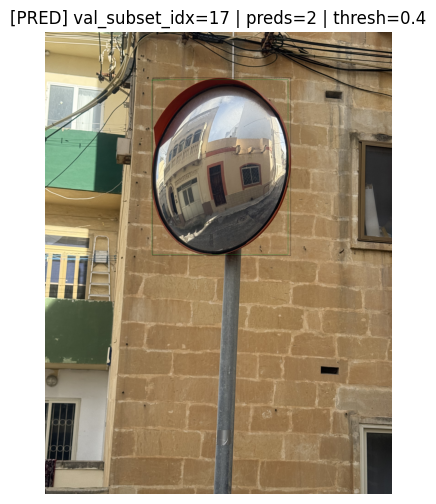

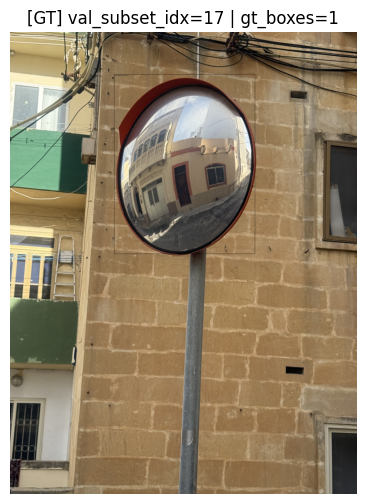

/home/nix/git/CV-Signs/.venv/lib/python3.13/site-packages/torchvision/utils.py:352: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


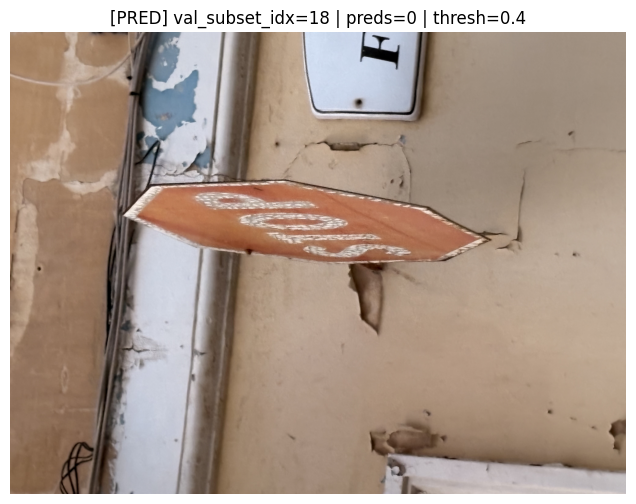

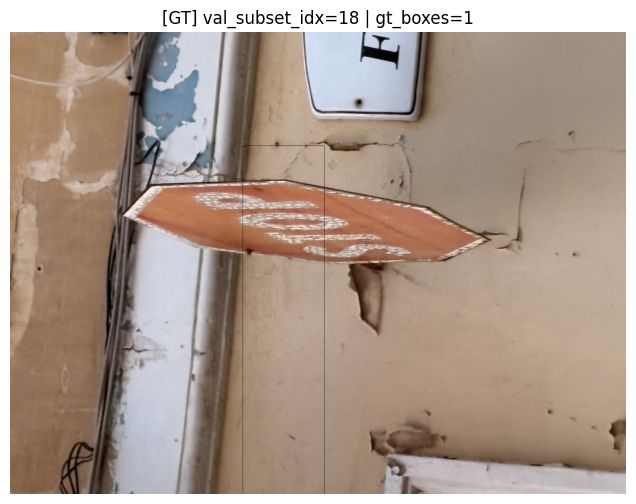

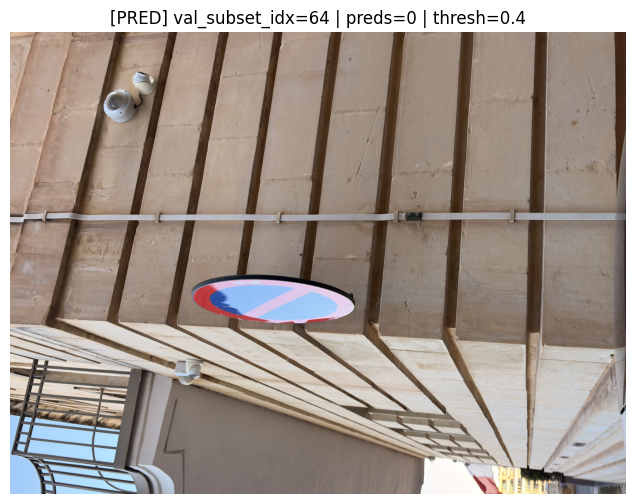

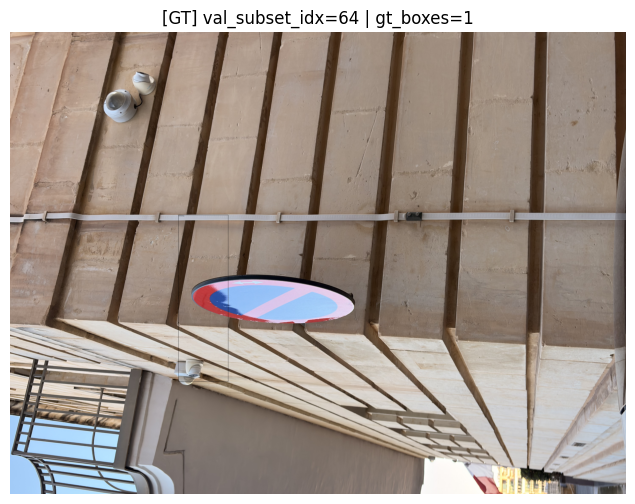

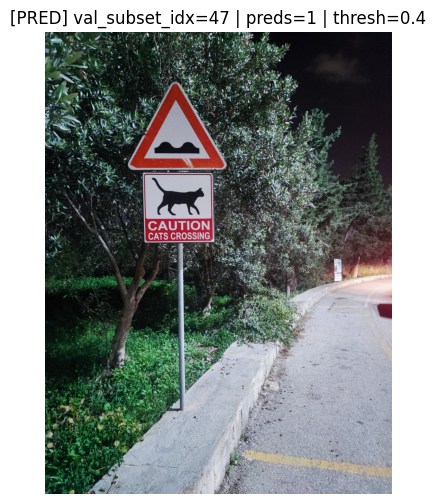

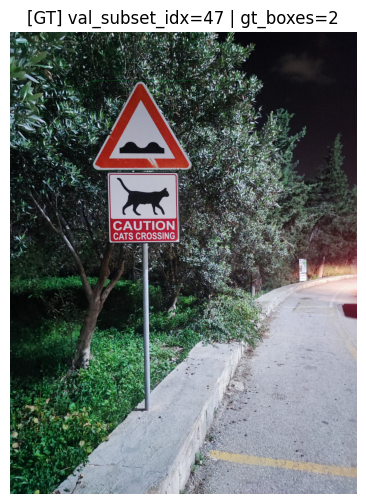

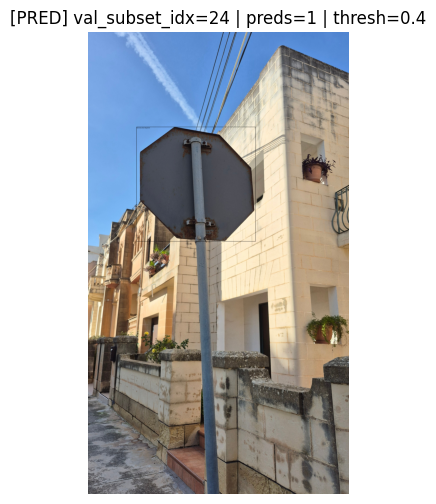

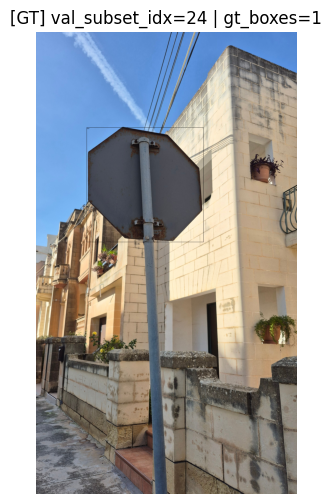

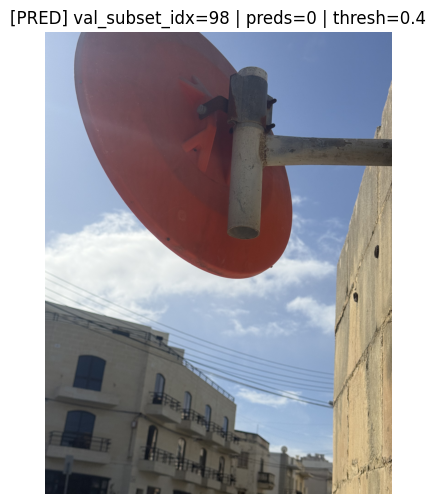

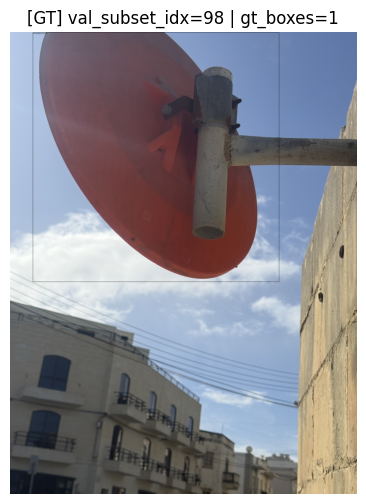

In [ ]:
@torch.no_grad()
def show_val_predictions(model, val_ds, base_dataset, n=8, score_thresh=0.4, seed=42):
    model.eval()
    g = torch.Generator().manual_seed(seed)

    idxs = torch.randint(low=0, high=len(val_ds), size=(n,), generator=g).tolist()

    for j, subset_idx in enumerate(idxs):
        img, tgt = val_ds[subset_idx]   
        out = model([img.to(device)])[0]

        keep = out["scores"] >= score_thresh
        p_boxes = out["boxes"][keep].cpu()
        p_scores = out["scores"][keep].cpu()
        p_labels = out["labels"][keep].cpu()

        pred_text = []
        for l, s in zip(p_labels.tolist(), p_scores.tolist()):
            name = base_dataset.contig_to_name.get(int(l), f"class{l}")
            pred_text.append(f"{name}:{s:.2f}")

        img_u8 = (img * 255).to(torch.uint8)
        pred_img = torchvision.utils.draw_bounding_boxes(
            img_u8, p_boxes, labels=pred_text, width=2
        )

        gt_boxes = tgt["boxes"].cpu()
        gt_labels = tgt["labels"].cpu()
        gt_text = [base_dataset.contig_to_name.get(int(l), f"class{l}") for l in gt_labels.tolist()]
        gt_img = torchvision.utils.draw_bounding_boxes(
            img_u8, gt_boxes, labels=gt_text, width=2
        )

        plt.figure(figsize=(12, 6))
        plt.imshow(pred_img.permute(1,2,0))
        plt.axis("off")
        plt.title(f"[PRED] val_subset_idx={subset_idx} | preds={len(p_boxes)} | thresh={score_thresh}")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.imshow(gt_img.permute(1,2,0))
        plt.axis("off")
        plt.title(f"[GT] val_subset_idx={subset_idx} | gt_boxes={len(gt_boxes)}")
        plt.show()

show_val_predictions(model, val_ds, dataset, n=6, score_thresh=0.4)
